## Import libraries

In [1]:
import os
import math
import json
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
from dtw import dtw
import altair as alt
import seaborn as sns
from scipy import stats
from vega_datasets import data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import InterclusterDistance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.figure(figsize=(20,5))

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]
RANDOM_SEED = 2048
R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

<Figure size 1440x360 with 0 Axes>

In [2]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df['delta'] = df['delta']
#dict of size
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }
color_scale = alt.Scale(domain=list(size_dict.values()))
hue_order = size_dict.values()

In [ ]:
columns = ['total_size', 'distance', 'task_around', 'lat', 'long', 'delta', 'cost']
LAT_AXIS = alt.X('lat', type='quantitative', scale=alt.Scale(domain=(-33.70, -33.15)), title='Latitude')
LONG_AXIS = alt.Y('long',type='quantitative', scale=alt.Scale(domain=(-70.4, -70.9)), title='Longitude')
DEN_AXIS = y=alt.Y('density', type='quantitative', title='Density')

## Utils functions

In [5]:
def create_quantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

def min_max_scaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

def get_similarity(obj1, obj2):
  len1 = len(obj1.columns)
  len2 = len(obj2.columns)
  if not (len1 == len2):
    print("Error: Compared objects must have same number of features")
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / len1)
    similarity = 1 - math.sqrt(similarity)
    return similarity

def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False, values=None):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  return_value = []
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if values is not None:
        difference.append(value)
      if diff:
        difference.append(value)
    if values is not None:
      return_value.append(difference[values])
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if values is not None:
    return return_value
  if diff:
    return pd.DataFrame.from_dict(differences)

def with_hue_unique(plot, total, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def remove_outlayers(dataframe: pd.DataFrame, feature: str, complete=False, limit=3):
  z_scores = stats.zscore(dataframe[feature])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < limit
  if complete:
    return dataframe[filtered_entries]
  return dataframe[ filtered_entries ][feature]


## Enmanuel Magallanes

## Dataset description

In [ ]:
plt.figure(figsize=(10,5))
g = sns.countplot(data=df, x='total_size', order=size_dict.values(), palette=PALETTE)
set_labels(None, 'Size', 'Frecuency')
with_hue_unique(g, len(df),list(size_dict.values()), 5, 1)

The dataset is mostly made up of Medium weighted tasks, with 65.8% of deliveries, and X Small weighted tasks, with 29.1% of deliveries. The Small, Large and X Long categories are the ones that appear the least in the dataset.

In [ ]:
df_ = remove_outlayers(df, 'distance', True)

colors = sns.color_palette("muted")
size_color = [ colors[2], colors[3], colors[0], colors[1], colors[4]  ]

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, y='distance', x='total_size', palette=size_color, order=size_dict.values())
gtg.set_ylabel('Distance')
gtg.set_xlabel('Total size')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='distance', hue='total_size',palette='muted')
gts.legend_.set_title('Total size')
gts.set_xlabel('Distance')

The task distance is very similar between the X Small, Medium and X Large weighted tasks. It has a median close to 20 and its distribution follows a similar shape, which is very slightly skewed to the right. On the other hand, the Small-weighted tasks have the smallest distance, with a median close to 10 and their distribution is strongly skewed to the right. Long-weighted tasks have a median close to 15 and are slightly skewed to the right.

In [ ]:
plt.figure(figsize=(10,5))
g = sns.countplot(data=df, x='delivery_type', palette=PALETTE)
set_labels(None, 'Delivery type', 'Frecuency')
with_hue_unique(g, len(df), list(df.delivery_type.unique()), 2, 1)

La mayor cantidad de tareas esta conformada por tareas de tipo Slot, las cuales son tareas que tienen una fecha de recolección, del o los paquetes, con una ventana de tiempo máxima de una hora desde la hora especificada. Por otro lado los paquetes de tipo flex, son aquellas tareas que su intervalo de recolección es mas de una hora, como máximo 12 horas.

In [ ]:
df_ = remove_outlayers(df, 'distance', True)

plt.tight_layout()
g = sns.FacetGrid(df_.sample(frac=0.25, random_state=RANDOM_SEED),
  row='delivery_type', col='total_size', col_order=hue_order
)
g.map_dataframe(sns.scatterplot, x='distance', y='cost')
g.set_axis_labels('Distance', 'Cost')
g.add_legend()
g.savefig('../img/delivery_type_grid.png')

From the graph we can determine that flex type deliveries are the ones that present a higher correlation between the cost and distance variables, mainly between deliveries with size X Small, Small and Large, are the ones that present a weak positive correlation between cost and distance.

In [ ]:
brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(data).mark_bar().encode(
  x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=40)), y='count()',
  color=alt.Color('Total size:N', scale=color_scale),
).properties(width=380, height=250)
background = base.encode(color=alt.value('#ddd')).add_selection(brush)

highlight = base.transform_filter(brush)
columns = ['total_size', 'distance', 'task_around']
data = df.sample(5000)[columns]
data.columns = ['Total size', 'Distance', 'Neighboring deliveries']
alt.layer(background, highlight, data=data).repeat(column=list(data.columns)[1:]).properties(title='Distance - Neighboring deliveries')

### Correlations (Distance - Cost)

In [ ]:
corrs = []
for size in df.total_size.sort_values().unique():
  for delivery_type in df.delivery_type.unique():
    corr = df[(df.total_size == size) & (df.delivery_type == delivery_type)][['distance', 'cost']].corr(method='spearman').iloc[1,0]
    corrs.append((size, delivery_type, corr))

corrs.sort(key=lambda x: x[2], reverse=True)
for corr in corrs:
  print('Correlation between {0:7s} - {1:4s}: {2:>10.6f}'.format(*corr))

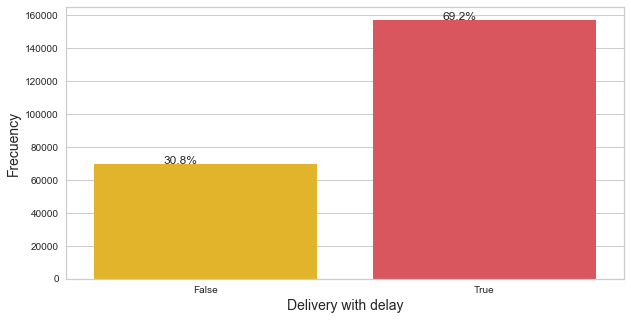

In [196]:
plt.figure(figsize=(10,5))
plt.tight_layout()
g = sns.countplot(data=df, x='is_late', palette=PALETTE)
set_labels(None, 'Delivery with delta', 'Frecuency')
g.figure.savefig('../data/is_late_dataset.png')
with_hue_unique(g, len(df), list(df.is_late.unique()), 2, 1)

The 69.2% the dataset are delivery with delta. The delta is the time that the delivery takes to be delivered, and it is calculated by subtracting the time of the delivery from the time of the collection.

In [194]:
"""DELIVERY LATE ANALISIS"""
df_delta = df[ df.is_late ]

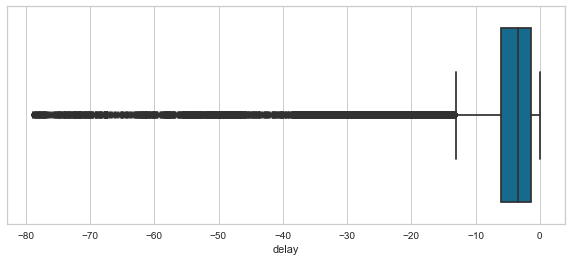

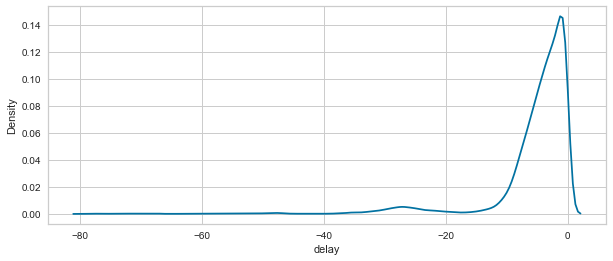

In [195]:
df_ = remove_outlayers(df_delta, 'delta', True)
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.boxplot(data=df_, x='delta')
plt.show()
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.kdeplot(data=df_, x='delta')

As the boxplot show, exits deliveries with up to 80 hours of delta. The median is close to 3 hours, and the distribution is skewed to the right.

### Temporal distribution delta
- Month
- Weeks
- Days

[(-5, 0)]

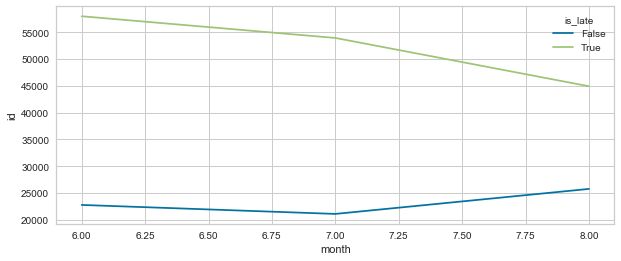

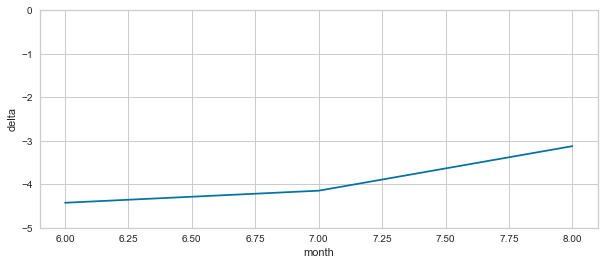

In [3]:
df_ = df.copy()

df_['month'] = df_.delivery_dt.dt.month
month_g = df_.groupby(['month', 'is_late'])['id'].count().reset_index()
month_g = month_g[ month_g.month < 9 ]
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=month_g, x='month', y='id', hue='is_late')

df_['month'] = df_.delivery_dt.dt.month
month_g_delta = df_.groupby('month')['delta'].mean().reset_index()
month_g_delta = month_g_delta[ month_g_delta.month < 9 ]
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=month_g_delta, x='month', y='delta').set(ylim=(-5,0))

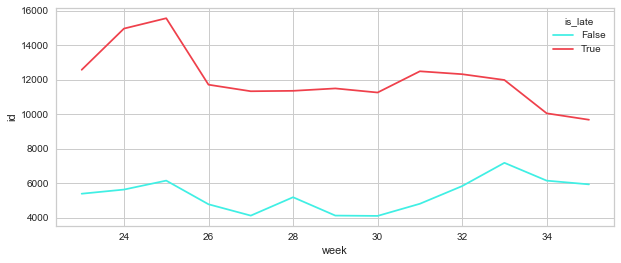

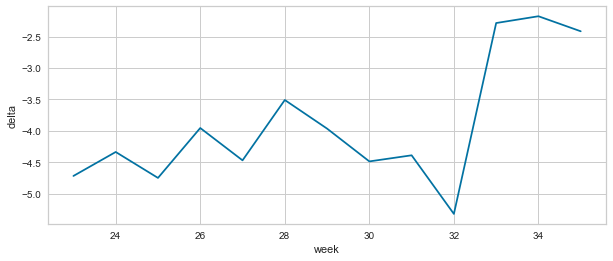

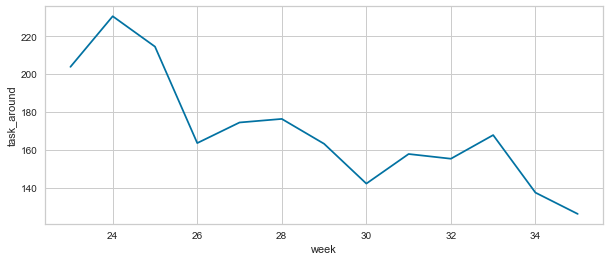

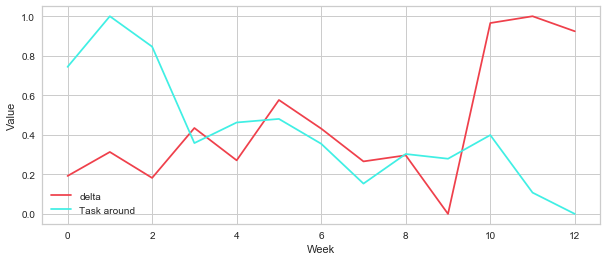

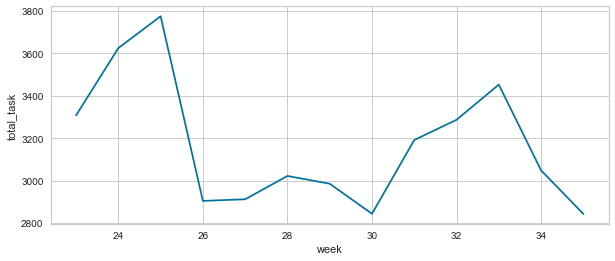

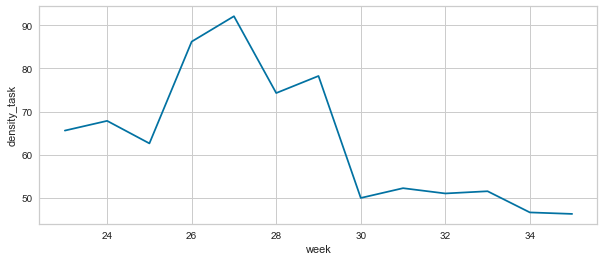

In [6]:
df_['week'] = df_.delivery_dt.dt.isocalendar().week
week_g = df_.groupby(['week', 'is_late'])['id'].count().reset_index()
week_g = week_g[ week_g.week < 36 ]
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=week_g, x='week', y='id', hue='is_late', palette=PALETTE_ALT)

week_g_delta = df_.groupby('week')['delta'].mean().reset_index()
week_g_delta = week_g_delta[ week_g_delta.week < 36 ]
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=week_g_delta, x='week', y='delta')

plt.figure(figsize=(10,4))
plt.tight_layout()
week_g_task = df_.groupby('week')['task_around'].mean().reset_index()
week_g_task = week_g_task[ week_g_task.week < 36 ]
sns.lineplot(data=week_g_task, x='week', y='task_around')

plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=min_max_scaler(week_g_delta.delta), color=PALETTE_ALT[1], label='delta')
sns.lineplot(data=min_max_scaler(week_g_task.task_around), color=PALETTE_ALT[0], label='Task around')
plt.ylabel('Value')
plt.xlabel('Week')

plt.figure(figsize=(10,4))
plt.tight_layout()
week_g_total = df_.groupby('week')['total_task'].mean().reset_index()
week_g_total = week_g_total[ week_g_total.week < 36 ]
sns.lineplot(data=week_g_total, x='week', y='total_task')

df_['density_task'] = (df_.task_around / df_.total_task) * 1e3
plt.figure(figsize=(10,4))
plt.tight_layout()
week_g_density = df_.groupby('week')['density_task'].mean().reset_index()
week_g_density = week_g_density[ week_g_density.week < 36 ]
sns.lineplot(data=week_g_density, x='week', y='density_task')

Podemos observar que el comportamiento del delta tiene a crecer durante el tiempo. mientras que la cantidad de entregas vecinas tiene cierta sensionalidad con una tendencia a decrecer, esta presenta picos en las semanas 24 (8 - 14 Junio), 28 (13 - 19 Julio) y 33 (10 - 16 Agosto) de año 2020. **Aparentemente se registran atrasos en tareas principalmente a mitad del mes.**

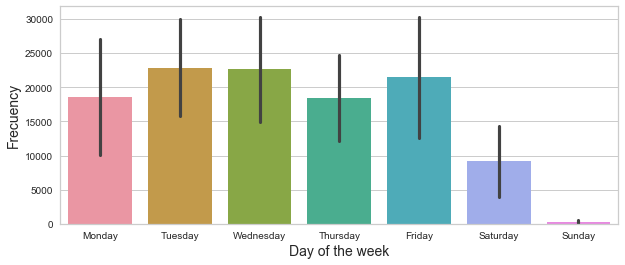

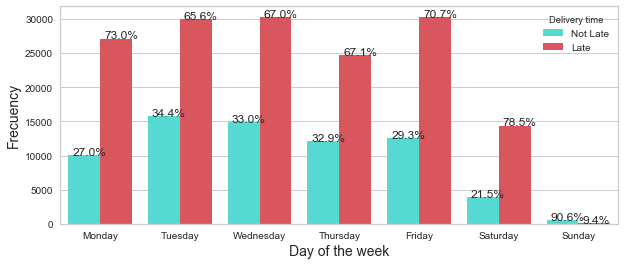

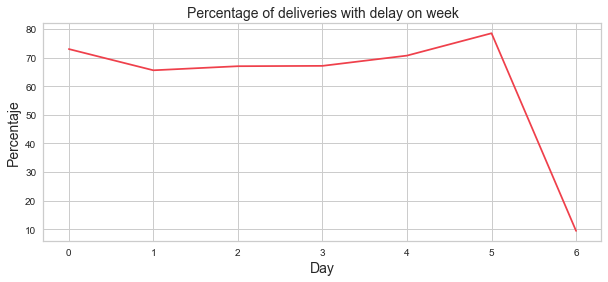

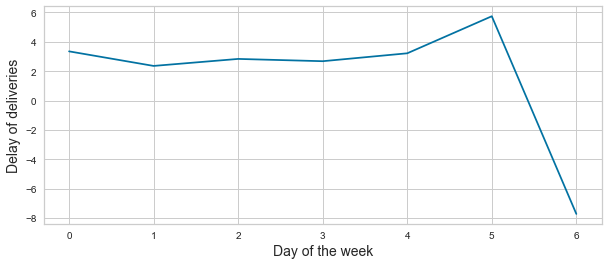

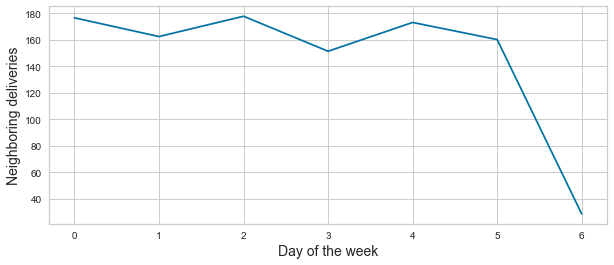

In [205]:
df_['day_name'] = df_.delivery_dt.dt.day_name()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_name_g = df_.groupby(['day_name', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(10,4))
plt.tight_layout()
gd = sns.barplot(data=day_name_g, x='day_name', y='id', order=days)
gd.figure.savefig('../data/delivery_day_name.png')
set_labels(None, 'Day of the week', 'Frecuency')

plt.figure(figsize=(10,4))
plt.tight_layout()
gdl = sns.barplot(data=day_name_g, x='day_name', y='id',hue='is_late', order=days, palette=PALETTE_ALT)
gdl.figure.savefig('../data/delivery_day_name_late.png')
set_labels(None, 'Day of the week', 'Frecuency', legend={'object': gdl.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']})
diffs = with_hue(gdl, days, 7, 2, values=1)

plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=diffs, color=PALETTE_ALT[1])
set_labels('Percentage of deliveries with delta on week', 'Day', 'Percentaje')

day_name_g_delta = remove_outlayers(df_, 'delta', True).groupby('day_name')['delta'].mean().reset_index()
day_name_g_delta['day_number'] = day_name_g_delta.day_name.apply(lambda x: days.index(x))
day_name_g_delta.delta = day_name_g_delta.delta * -1
plt.figure(figsize=(10,4))
plt.tight_layout()
sns.lineplot(data=day_name_g_delta, x='day_number', y='delta')
set_labels(None, 'Day of the week', 'delta of deliveries')

day_name_g_task = remove_outlayers(df_, 'task_around', True).groupby('day_name')['task_around'].mean().reset_index()
day_name_g_task['day_number'] = day_name_g_task.day_name.apply(lambda x: days.index(x))
plt.figure(figsize=(10,4))
plt.tight_layout()
day_name_g_task['day_number'] = day_name_g_task.day_name.apply(lambda x: days.index(x))
sns.lineplot(data=day_name_g_task, x='day_number', y='task_around')
set_labels(None, 'Day of the week', 'Neighboring deliveries')

In [7]:
df_['day_of_year'] = df_.delivery_dt.dt.dayofyear
df_ = df_[ df_.week < 36 ]
g_corr = remove_outlayers(df_, 'delta', True).groupby('week')['delta'].mean().reset_index()
g_corr['task_around'] = remove_outlayers(df_, 'task_around', True).groupby('week')['task_around'].mean().reset_index()['task_around']
g_corr[['delta', 'task_around']].corr(method='spearman')

,delta,task_around
delta,1.000000,-0.637363
task_around,-0.637363,1.000000


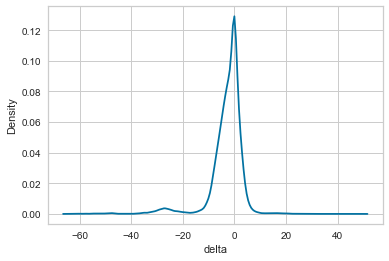

In [15]:
sns.kdeplot(data=remove_outlayers(df_, 'delta', True, 3), x='delta')

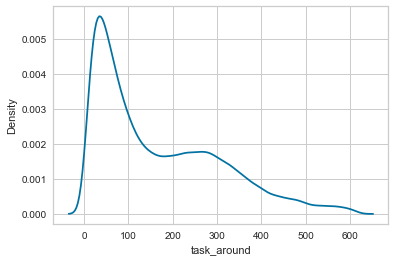

In [14]:
sns.kdeplot(data=remove_outlayers(df_, 'task_around', True, 3), x='task_around')

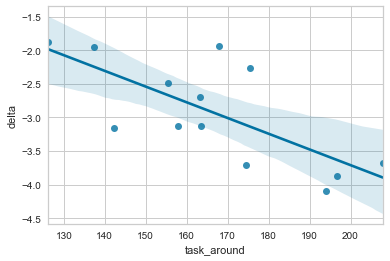

In [221]:
sns.regplot(data=g_corr, x='task_around', y='delta')

Como se puede observar en las graficas, desde el lunes hasta el sabado se presenta una gran cantidad de entregas con delta, siendo los Lunes, Viernes y Sabados los dias con mayor porcentaje de entregas con delta. Adicionalmente, de Lunes a Sabados el delta de los deliveries es basntante similar, siendo el Sabado el dia que se registra un aumento en los retrasos y el Domingo el dia que se registran menos retrasos.

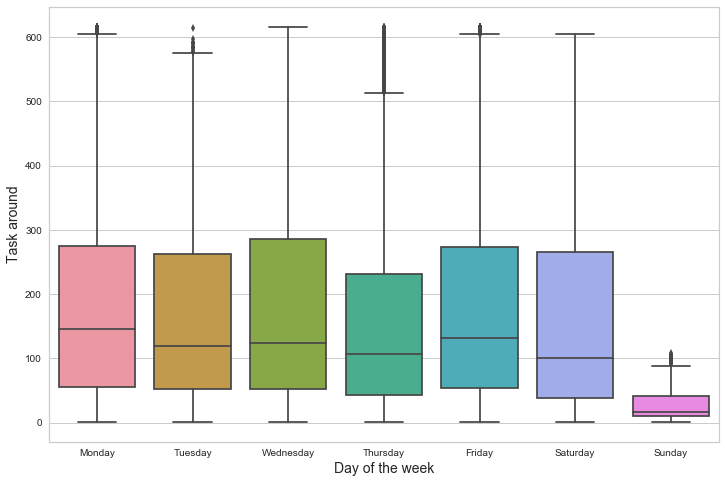

In [106]:
# Analysis on Monday, Friday, Saturday and Sunday of Total task and task around variables
df_days = df_[ df_.day_name.isin(['Monday', 'Friday', 'Saturday', 'Sunday']) ]
focus_days = [ 'Monday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.boxplot(data=remove_outlayers(df_, 'task_around', True), x='day_name', y='task_around', order=days)
set_labels(None, 'Day of the week', 'Task around')

### Moran index (Pysal) geostatistical analysis
### Grid of bounded box with delta as metric

## Question: Is the total size of packages a factor affecting the timeliness of deliveries?

In [ ]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
diff_size = with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_size, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by total size of delivery',
  x_label='Class of size of deliveries', y_label='Amount of deliveries'
)

## Question 2: Are tasks with fewer neighboring deliveries* taking longer to reach their delivery point?
\* We define neighboring deliveries as all those deliveries that are less than or equal to X KM away from the same and their delivery date is within T hours of the same.

In [ ]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [ ]:
# Remoiving outlayers using the z-score
task_around_filtered = remove_outlayers(df, 'task_around')

fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of neighboring deliveries')
ax[0].set_xlabel('Neighboring deliveries')
sns.kdeplot(data=task_around_filtered, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of neighboring deliveries')
ax[1].set_xlabel('Neighboring deliveries')
sns.boxenplot(data=task_around_filtered, ax=ax[1], color=PALETTE[1])

print('Mean neighboring deliveries: {0:.2f} deliveries'.format(task_around_filtered.mean()))
print('STD neighboring deliveries: {0:.2f}'.format(task_around_filtered.std()))

In [ ]:
df['class_neighboring'] = pd.cut(
  df['task_around'], 
  include_lowest=True,
  bins=[x for x in range(0, 900, 100)]
)

gnl = df[['id', 'class_neighboring', 'is_late']].groupby(['class_neighboring', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gnl, x='class_neighboring', y='id', hue='is_late', palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per class of neighboring deliverie', 'Bind of neighboring deliveries', 'Amount of deliveries', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
classes_list = list(map(lambda item: str(item), df['class_neighboring'].sort_values().unique()))
diff_list = with_hue(f, classes_list, 8, 2, diff=True)

In the plot we can see that as the number of neighboring deliveries increases, the percentage of late deliveries also increases. This tells us that the higher the concentration or density of deliveries around you, the more likely it is that you will be late in reaching the final customer

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_list, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by number of neighboring deliveries',
  x_label='Class of amount of neighboring deliveries', y_label='Amount of deliveries'
)

In [ ]:
plt.figure(figsize=(10,5))
plt.tight_layout()
g = sns.scatterplot(data=df.sample(frac=0.3, random_state=RANDOM_SEED).sort_values(by='task_around', ascending=True),
  x='lat', y='long', hue='task_around', palette='flare', size='total_size', size_order=hue_order, sizes=(50, 250)
)
g.set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))
g.figure.savefig('../img/location_nd.png')


In [ ]:
plt.figure(figsize=(10,10))
plt.tight_layout()
g = sns.scatterplot(data=remove_outlayers(df.sample(100000), 'delta', True), x='delta', y='task_around')
#change scale to log
g.set(yscale='log')

In [ ]:
plt.figure(figsize=(10,10))
plt.tight_layout()
sns.scatterplot(data=remove_outlayers(df.sample(80000), 'delta', True), x='delta', y='total_task')

In [ ]:
plt.figure(figsize=(10,10))
plt.tight_layout()
sns.scatterplot(data=remove_outlayers(df.sample(80000), 'delta', True), x='task_around', y='total_task')

There is a high concentration of deliveries with a high number of neighboring deliveries at one point on the map. On the other hand, the further away from that point the number of neighboring deliveries decreases and deliveries larger than Medium are more frequent.

In [ ]:
data = remove_outlayers(df.sample(5000)[columns], 'task_around', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1],).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="task_around", as_=['task_around', 'density'],).mark_area().encode(
  x=alt.X('task_around', type='quantitative', title='Neighboring deliveries'), y=DEN_AXIS
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by Neighborign deliveries')
# circulos de colores

En la figura podemos ver que existe una alta concentracion de entregas con una alta cnantidad de entregs vecinas en un punto muy concreto del mapa y que mayormente son de un tamaño menor a Medium. Por otro lado las cantidad de entregas vecinas disminuye conforme la ubicacion de la tarea del circula de entregas con mas tareas vecinas y tambien el tamaño de dichas tareas suele ser mas grande 

In [ ]:
data = remove_outlayers(df.sample(5000)[columns], 'distance', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1],).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data).transform_density(density="distance", as_=['distance', 'density']).mark_area().encode(
  x=alt.X('distance', type='quantitative', title='Distnace'), 
  y=DEN_AXIS
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by distance value')

In [ ]:
data = remove_outlayers(df.sample(5000)[columns], 'delta', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1]).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="delta", as_=['delta', 'density']).mark_area().encode(
  x=alt.X('delta', type='quantitative', title='delta delivery'), y=DEN_AXIS,
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by distance value')

In [ ]:
data = remove_outlayers(df.sample(5000)[columns], 'cost', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1]).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="cost",as_=['cost', 'density']).mark_area().encode(
  x=alt.X('cost', type='quantitative',title='Cost'), y=DEN_AXIS,
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns])

## Ploting location of task with low and hight neighboring deliveries 

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delta_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [ ]:
def get_color(tasks):
  """Get color for task"""
  if tasks == 0:
    return 'black'
  elif 0 <= tasks < 300:
    return 'blue'
  elif 300 <= tasks < 1000:
    return 'red'

def add_marker(row, map_stg):
  folium.Marker(
    location=[row['lat'], row['long']],
    popup=row['id'],
    icon=folium.Icon(color=get_color(row['task_around']))
  ).add_to(map_stg)

stg_map = folium.Map(location=[-33.469477, -70.643929], zoom_start=12)
a = df \
[['lat', 'long', 'id', 'class_neighboring', 'task_around']].sample(100).apply(
  lambda r: add_marker(r, stg_map), axis=1
)
show_map = None
if False:
  show_map = stg_map
show_map

## Question 3: What are the common characteristics of the tasks with delta on delivery time?
### Clustering (KMeans)

### Data normaliation
- Power law distribution: apply log transform scale [0,1]
- A normal (gaussian) distribution: apply normalization [0,1] (z-score, min-max, divide by max)
- Any diferent distribution (like bimodal or possion): apply quantiles [0,1] (bins)

In [ ]:
features = [
  'distance', 'cost', 'delta', 'lat', 'long', 'task_around', #numerical variables
  'delivery_type', 'total_size', # categorical variables
]
stad_dt = ['delivery_dt', 'pickup_effective_dt']

In [ ]:
original_cols = df.columns

dff = df.copy()
dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes
dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes
#dff[features]

The `total_size` is a categorical variable, so we will use the raw value for clustering and max-min normalization.

In [ ]:
feature_clean = remove_outlayers(dff, 'distance')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/distance_dist.pdf')

The `distance` variable don't have a clear distribution, so we will use quantiles and max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, 'lat')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/lat_dist.pdf')

The `lat` variable don't have a clear distribution, so we will use max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, 'long')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/long_dist.pdf')

The `long` variable don't have a clear distribution, so we will use the max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, 'task_around')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/task_a_dist.pdf')

The `task_around` variable doesn't follow a known distribution. In this case we will use max-min normalization.

In [ ]:
feature_clean = remove_outlayers(dff, 'cost')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/cost_dist.pdf')

The `cost` variable doesn't follow a known distribution. In this case we will use max-min normalization in this variable for clustering

In [ ]:
feature_clean = remove_outlayers(dff, 'delta')
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True).figure.savefig('../img/deslta_dist.pdf')

The `delta` variable doesn't follow a known distribution. In this case we will use max-min normalization in this variable for clustering

### Similarity metrics
We choose the cosine distance has a similarity metric.

In [ ]:
# Task random A
task_random_a = dff.sample(1)[features]
# Task random B
task_random_b = dff.sample(1)[features]
# Similarity
similarity = cosine_similarity(task_random_a, task_random_b)
print(f'Similarity: {similarity}')
display('task_random_a', 'task_random_b')

### Apply max-min normalization for clustering

In [ ]:
""" dff.distance = create_quantiles(dff.distance, 10) # 30
dff.cost = create_quantiles(dff.cost, 7)
dff.delta = create_quantiles(dff.delta, 10)
dff.lat = create_quantiles(dff.lat, 10)
dff.long = create_quantiles(dff.long, 10)
dff.task_around = create_quantiles(dff.task_around, 5) """

""" dff.distance = create_quantiles(dff.distance, 10) # 30
dff.cost = create_quantiles(dff.cost, 3)
dff.delta = create_quantiles(dff.delta, 10)
dff.lat = create_quantiles(dff.lat, 10)
dff.long = create_quantiles(dff.long, 10)
dff.task_around = create_quantiles(dff.task_around, 4) """

""" dff.distance = create_quantiles(dff.distance, 10) # 30
dff.cost = create_quantiles(dff.cost, 3)
dff.delta = create_quantiles(dff.delta, 3)
dff.lat = create_quantiles(dff.lat, 10)
dff.long = create_quantiles(dff.long, 10)
dff.task_around = create_quantiles(dff.task_around, 4) """

dff.distance = create_quantiles(dff.distance, 10) # 30
dff.cost = create_quantiles(dff.cost, 3)
dff.delta = create_quantiles(dff.delta, 3)
dff.lat = create_quantiles(dff.lat, 10)
dff.long = create_quantiles(dff.long, 10)
dff.task_around = create_quantiles(dff.task_around, 4)

scaler = MinMaxScaler(feature_range=(0,100))
dff[features] = scaler.fit_transform(dff[features])

In [ ]:
dff[features]

In [ ]:
RAMDOM_SEED = 2048
dff_features = dff[features]
model = KMeans(init='k-means++', random_state=RAMDOM_SEED)
try:
  visualizer = KElbowVisualizer(model, k=(2,9), timings=True)
  visualizer.fit(dff_features)
  visualizer.figure.savefig('../img/elbow.pdf')
except:
  pass

In [ ]:
model = KMeans(n_clusters=visualizer.elbow_value_, init='k-means++', random_state=RAMDOM_SEED)
model.fit(dff_features)
df['cluster']= model.predict(dff_features)

plt.figure(figsize=(10,8))
interDistance = InterclusterDistance(model, random_state=RAMDOM_SEED)
interDistance.fit(dff_features)
interDistance.show()
print(interDistance.scores_)

El efecto de estadarizar los features o no si cambia el comportamiento de los clusters, sin estandarizacion el grafico de distancia inter-cluster muestra un aparente overlaping estre casi todos los clusters. Si bien, este overlaping en dos dimenciones no es indicador de overlaping en las dimenciones reales, es un indicador de que la calidad de los clusters no es la mejor y que estan bastante cerca entre ellos.

Con la estadrizacion de las variables la cantidad de cluster recoemndada por Elbow method tambien cambio de 5 clusters a solo 3. Ahora, el graifco de inter-cluster distance muestra una mejora en la distribucion de los clusters los cuales estan mucho mas separados entre ellos.

In [ ]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.scatterplot(data=df, x='lat', y='long', hue='cluster').set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))

In [ ]:
for cluster in range(visualizer.elbow_value_):
  print('Cluster {} size: {}'.format(cluster, len(df[ df['cluster'] == cluster ][features])))
print(f'Feature used: {", ".join(features)}')

In [ ]:
columns = ['total_size', 'distance', 'task_around']
df_ = remove_outlayers(df, 'task_around', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='task_around', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of neighbording deliveries')
gtg.set_ylabel('neighbording deliveries')
gtg.figure.savefig('../img/ng_s.pdf')
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='task_around', hue='cluster', palette='muted')
gts.set_title('Density of neighbording deliveries')
gts.set_xlabel('neighbording deliveries')

In this graph is show a `boxenplot`. It is similar to a box plot in plotting a nonparametric representation of a distribution in which all features correspond to actual observations. By plotting more quantiles, it provides more information about the shape of the distribution, particularly in the tails.

En los boxplot podemos obsrevar que los clusters 0 y 2 mantienen una mediana muy similar, siendo la mas baja de los 2 clusters, con la diferencia de que en el cluster 0 contiene densidad de valores mas alta que el clsuters 0 en valores cercanos a 600 entregas vecinas. El clsuter 1 es quien tiene una mediana mas alta de los 3 clusters, con un rango tambien el mas amplio de los 3.

En el kdeplot podemos observar que la forma de las distribuciones es banstante similar entre los clusters, sin embargo, el cluster 1 es el que tiene un densidad mas alta de entregas vecinas que el reststo. El cluster 2 es el que menos densidad de tareas vecinas presenta.

In [ ]:
df_ = remove_outlayers(df, 'cost', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='cost', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of cost')
gtg.figure.savefig('../img/cost_s.pdf')
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='cost', hue='cluster', palette='muted')
gts.set_title('Density of Neighbod deliveries')

En el boxplot podemos observar como entre el cluster 0 y 2 la mediana del costo para las entregas es similar entre ellos, siendo las mas alta de los 3 clusters. Sin embargo, el clsuter 2 tiene un rango de valores mucho mas amplio, llegando hasta los 4000 pesos chilenos con mas densidad de valores, el cluster 0 tiene un rango mas pequeño, entre 1200 y 2300 pesos chilenos. El cluster 1 es quien tiene la mediana mas pequeña y sus valores tienen una alta concentracion entorno a esa media, que es aprox 1400 pesos chilenos.

En el kdeplot podemos observar como claramente el clsuter 1 presenta una altisima densidad de tareas con un costo entre los valores de 100 y 200 dolares. El cluster 0 tiene pequeñas conncetraciones entre el rango de 100 y 2000 dolares, sin embargo, es mucho menos que el clsuter 1. Finalmente el cluster 2 es el que presenta la concentracion mas baja.

In [ ]:
df_ = remove_outlayers(df, 'distance', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='distance', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of distance')
gtg.figure.savefig('../img/distance_s.pdf')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='distance', hue='cluster', palette='muted')
gts.set_title('Density of distance')

En los boxplot podemos observar que todas las medianas son diferentes, donde el cluster 2 es quien tiene la mediana mas vaja, es decir entregas con una distancia, en general, mas corta y su rango de valores es la mas estrecha de los 3 clusters. Luego le sigue el cluster 0, es quien tiene una mediana entre el cluster 1 y 2, con una distribución muy similar al cluster 1. Finalmente el cluster 1 es quien tiene la mediana mas alta, es decir, con entregas con una distancia mas larga y su distribucion tiene picos en los valores de 10, 15 y 20 km.

En el kdeplot, podmeos observar como el cluster 1 es el que presenta una densidad alta de entregas con distnacias entre 10 y 30 km, el cluster 0 tiene un comportamiento similar y por ultimo el cluster 2 tiene una conentracion mas alta entre los valores de 0 y 10 km.

In [ ]:
df_ = remove_outlayers(df, 'delta', True, limit=0.5)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='delta', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of delta')
gtg.figure.savefig('../img/delta_s.pdf')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='delta', hue='cluster', palette='muted')
gts.set_title('Density of delta')
gts.set_xlim(-25, 25)

In [ ]:
df_ = remove_outlayers(df, 'lat', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='lat', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of lat')
gtg.figure.savefig('../img/lat_s.pdf')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='lat', hue='cluster', palette='muted')
gts.set_title('Density of latitude')

In [ ]:
df_ = remove_outlayers(df, 'long', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxplot(data=df_, x='cluster', y='long', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of long')
gtg.figure.savefig('../img/long_s.pdf')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='long', hue='cluster', palette='muted')
gts.set_title('Density of longitude')

In [ ]:
sns.scatterplot(data=df[ df['cluster'] == 1 ], x='lat', y='long', hue='cluster').set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))

En el boxplot y kdeplot podeos observar que el valor de delta es escalonado entre los clusters. El cluster 1 es quien tiene el valor de delta mas bajo, luego le sigue el clsuter 0 y por ultimo el cluster 2. Todos los clsuters tiene una distribucion bastante similar, muy estrecha entorno a la mediana.

## Cluster 0
This cluster contains deliveries that arrive on time. The distances present in this cluster are the shortest of all clusters. The payment received by the shipper is close to but below the global average. Finally, the concentration of neighboring deliveries is the lowest along with cluster 3.

## Cluster 1
This cluster presents tasks that register a high delta at the time of their deliveries. The distances are the longest of the clusters. However, the payment received by the shipper is the lowest of all clusters. Finally, they have a high concentration of neighboring deliveries.

## Cluster 2
This cluster has slightly backlogged tasks. The distances are the second highest of all clusters. In this occasion shippers are paid very close to the global average. Finally, the number of neighboring deliveries is the lowest of all clusters.

## Cluster 3
This cluster contains deliveries that arrive on time. The delivery distances are the second shortest, only behind Cluster 0, and the payment received by the shipper is also low. Finally, the concentration of neighboring deliveries is the lowest along with cluster 0 deliveries.

## Summary
Clusters 1 and 2 are the ones with late deliveries. Conditions such as a very low payment to shippers and a longer delivery distance and high number of neighbors are conditions that cause deliveries to suffer a high delta at the time of delivery.

## Josue Cobos

In [ ]:
g = sns.countplot(data=df_t, x='hight_neight', color=PALETTE_ALT[1])
g.set_xticks([0,1])

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delta?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delta_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delta_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delta of shipments (delta_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delta time.